# Gráficos

Dataset

- Histograma cantidad ratings por usuario
- Histograma de valores de ratings
- Histograma de cantidad de ratings por película (afecta colaborativo? real shit?)
- Pie chart de generos

Resultados

- Coverage (https://towardsdatascience.com/evaluation-metrics-for-recommender-systems-df56c6611093)


- Métricas
  - mark y mapk
  - personalización
  - coverage

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
sns.set_style("whitegrid")


## Dataset

### Pie chart de géneros

In [5]:
BASE_PATH = "dataset"
movies = pd.read_csv(f"{BASE_PATH}/movies_metadata.csv", low_memory=False, dtype={'id':str, 'original_title':str})

user_ratings = pd.read_csv(f"{BASE_PATH}/ratings.csv", dtype={'userId': str, 'movieId': str, 'rating': float,'timestamp': int})
id_links = pd.read_csv(f"{BASE_PATH}/links.csv", dtype={'movieId': str, 'imdbId': str, 'tmdbId': str})
user_ratings = pd.merge(user_ratings, id_links, left_on='movieId', right_on='movieId', how='left')

In [4]:
import json

genre_to_count = {}
genres = movies["genres"]

for genre in tqdm(genres):
    parsed_genre = json.loads(genre.replace("'", '"'))
    # [{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]
    for item in parsed_genre:
        name = item['name']
        if name not in genre_to_count:
            genre_to_count[name] = 0
        
        genre_to_count[name] = genre_to_count[name] + 1


In [5]:
genre_to_count = dict(sorted(genre_to_count.items(), key=lambda item: item[1], reverse=True)[:20])

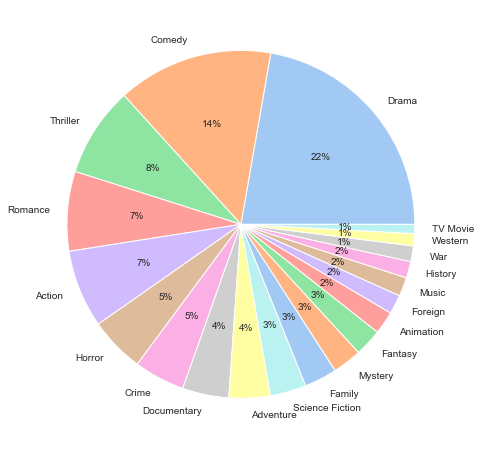

In [179]:
colors = sns.color_palette('pastel')
#create pie chart
plt.figure(figsize = (15,8))
plt.pie(genre_to_count.values(), labels = genre_to_count.keys(), colors = colors, autopct='%.0f%%')
plt.savefig("graficos/pie-generos.svg")
plt.show()

### Histograma de cantidad de ratings por película

In [180]:
ratings_by_movie = user_ratings.groupby("tmdbId").count().reset_index()
ratings_by_movie["num_ratings"] = ratings_by_movie["rating"]
ratings_by_movie = ratings_by_movie[["tmdbId", "num_ratings"]]

In [87]:
ratings_by_movie.sort_values("num_ratings", ascending=False)

,tmdbId,num_ratings
4949,13,91921
19373,278,91082
38387,680,87901
19009,274,84078
36693,603,77960
...,...,...
10903,183015,1
22783,318832,1
22781,318794,1
6933,145244,1


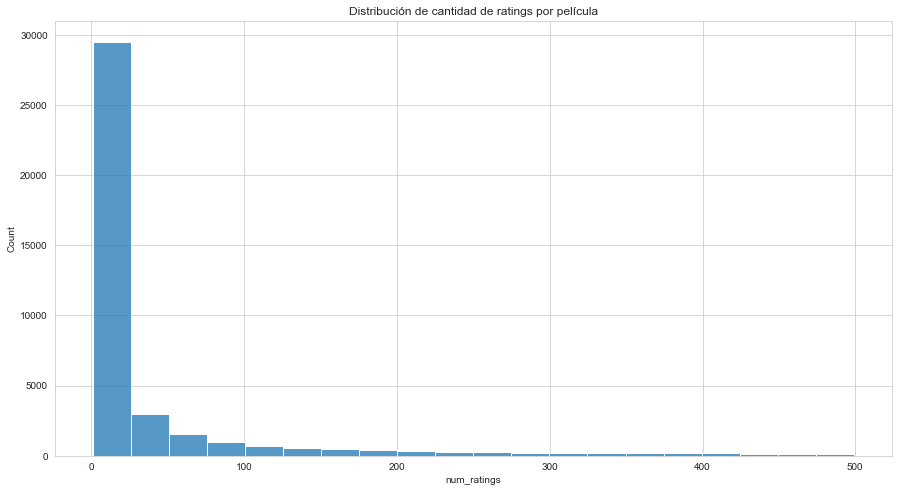

In [181]:
plt.figure(figsize = (15,8))
sns.histplot(data=ratings_by_movie[ratings_by_movie["num_ratings"] < 500], x="num_ratings", bins=20)
plt.title("Distribución de cantidad de ratings por película")
plt.savefig("graficos/hist-ratings-por-movie.svg")

### Histograma cantidad ratings por usuario

In [182]:
ratings_by_user = user_ratings.groupby("userId").count().reset_index()
ratings_by_user["num_ratings"] = ratings_by_user["rating"]
ratings_by_user = ratings_by_user[["userId", "num_ratings"]]

In [111]:
ratings_by_user

,userId,num_ratings
0,1,27
1,10,13
2,100,3
3,1000,6
4,10000,10
...,...,...
270891,99995,129
270892,99996,134
270893,99997,62
270894,99998,16


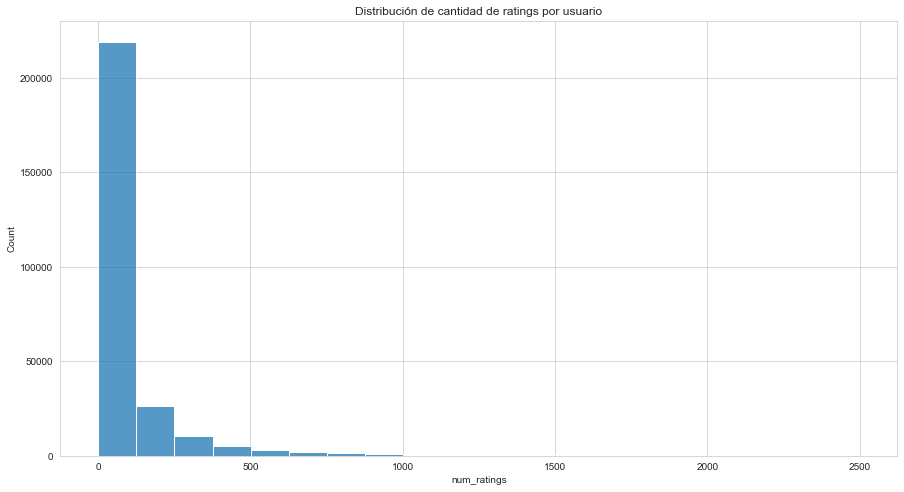

In [183]:
plt.figure(figsize = (15,8))
sns.histplot(data=ratings_by_user[ratings_by_user["num_ratings"] < 2500], x="num_ratings", bins=20)
plt.title("Distribución de cantidad de ratings por usuario")
plt.savefig("graficos/hist-ratings-por-user.svg")

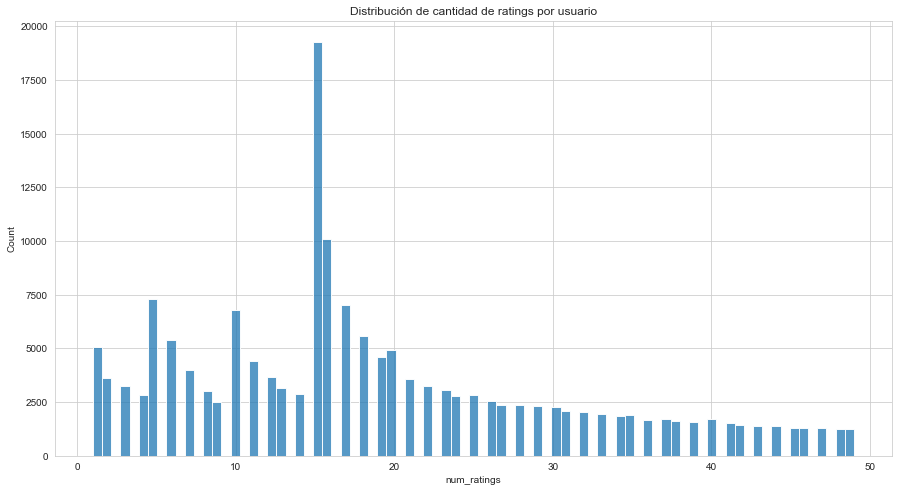

In [185]:
plt.figure(figsize = (15,8))
sns.histplot(data=ratings_by_user[ratings_by_user["num_ratings"] < 50], x="num_ratings")
plt.title("Distribución de cantidad de ratings por usuario")
plt.savefig("graficos/hist-ratings-por-user.svg")

### Histograma de valores de ratings

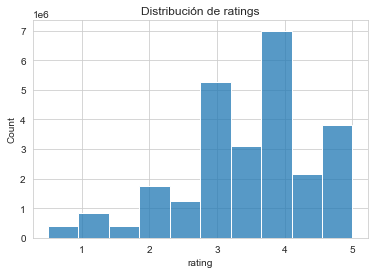

In [186]:
sns.histplot(data=user_ratings, x="rating", bins=10)
plt.title("Distribución de ratings")
plt.savefig("graficos/ratings-dist.svg")

## Resultados

In [3]:
import result_io
import average_precision
import recmetrics.metrics

### Tests de mark y mapk

In [146]:
import recmetrics

actual = [[1, 2, 3], [4, 5, 6]]
predicted_unord = [[3, 2, 1], [6, 5, 4]]

recmetrics.metrics.mark(actual, predicted_unord, k=3)

1.0

In [6]:
catalog = list(movies["id"].unique())

Veredicto: no es importante el orden

## Content

In [11]:
predicted_content, actual_content = 

In [12]:
predicted_collab, actual_collab = 

In [13]:
predicted_random, actual_random = 

In [19]:
data = {
    "content": result_io.read_results(result_io.NAME_CONTENT),
    "content-sopa": result_io.read_results_new_format(result_io.NAME_CONTENT_SOPA),
    "collab": result_io.read_col_results(),
    "random": result_io.read_results(result_io.NAME_RANDOM),
}

In [20]:
rows = []
for algo, val in data.items():
    pred, actual = val
    for k in range(1,11):
        mark = recmetrics.metrics.mark(actual, pred, k=k)
        mapk = average_precision.mapk(actual, pred, k=k)
        rows.append({"k": k, "mark": mark, "mapk": mapk, "algorithm": algo})
df = pd.DataFrame.from_records(rows)

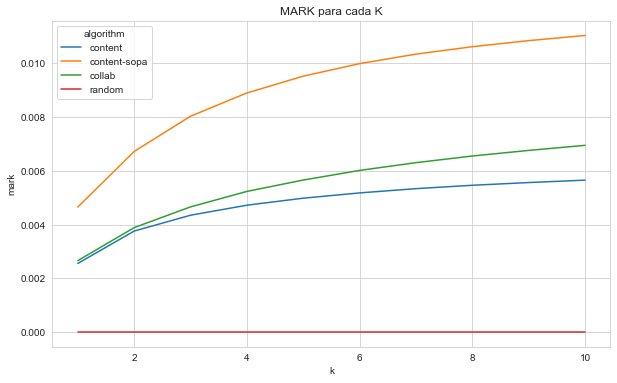

In [42]:
plt.figure(figsize = (10,6))
sns.lineplot(
    data=df,
    x="k", y="mark", hue="algorithm",
    markers=True, dashes=False
)
plt.title("MARK para cada K")
plt.savefig("graficos/resultados/mark.png")

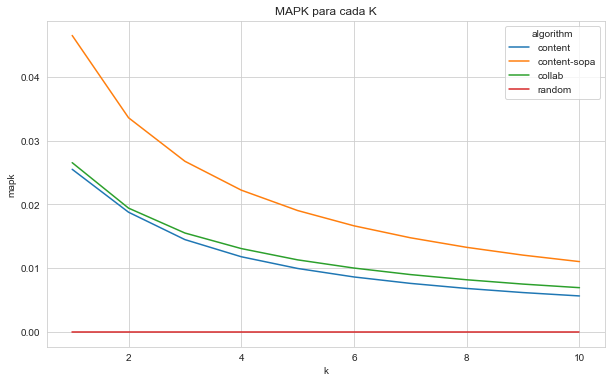

In [43]:
plt.figure(figsize = (10,6))
sns.lineplot(
    data=df,
    x="k", y="mapk", hue="algorithm",
    markers=True, dashes=False
)
plt.title("MAPK para cada K")
plt.savefig("graficos/resultados/mapk.png")

In [30]:
rows = []
for algo, val in data.items():
    all_pred, all_actual = val
    for k in range(1,11):
        i = 0
        for actual, pred in zip(all_pred, all_actual):
            apk = average_precision.apk(actual, pred, k) 
            ark = recmetrics.metrics._ark(actual, pred, k=k)
            rows.append({"i": i, "k": k, "apk": apk, "ark": ark, "algorithm": algo})
            i+=1

df_sep = pd.DataFrame.from_records(rows)

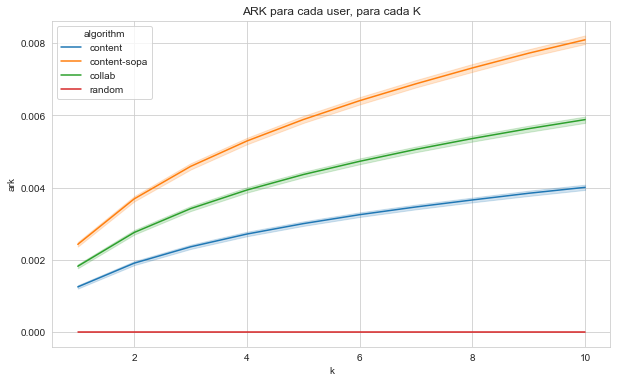

In [44]:
plt.figure(figsize = (10,6))
sns.lineplot(
    data=df_sep,
    x="k", y="ark", hue="algorithm",
    markers=True, dashes=False
)
plt.title("ARK para cada user, para cada K")
plt.savefig("graficos/resultados/ark.png")

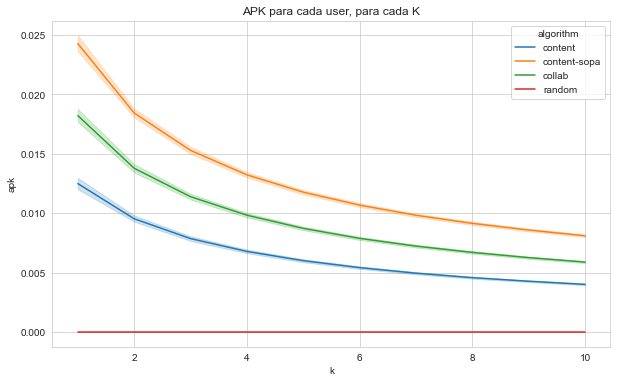

In [46]:
plt.figure(figsize = (10,6))
sns.lineplot(
    data=df_sep,
    x="k", y="apk", hue="algorithm",
    markers=True, dashes=False
)
plt.title("APK para cada user, para cada K")
plt.savefig("graficos/resultados/apk.png")

In [23]:
recmetrics.metrics.prediction_coverage(predicted_content, catalog)

39.4

In [ ]:
recmetrics.metrics.personalization(predicted_content)